dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
images: 4178
annotations: 196420
categories: 4


,id,license,file_name,height,width,date_captured,extra
0,0,1,3209_png.rf.484a160a33222f9b8cbd8878521b2a7a.jpg,640,640,2025-06-05T04:33:21+00:00,{'name': '3209.png'}
1,1,1,10285_png.rf.cb3a593365d9586b337dc47ca2ae3b66.jpg,640,640,2025-06-05T04:33:21+00:00,{'name': '10285.png'}
2,2,1,6225_png.rf.2ec651b693a8592baae58e5d7aedd706.jpg,640,640,2025-06-05T04:33:21+00:00,{'name': '6225.png'}
3,3,1,6220_png.rf.dec6f47f7fc631c45eec0228aec324a1.jpg,640,640,2025-06-05T04:33:21+00:00,{'name': '6220.png'}
4,4,1,10479_png.rf.ea9281c0431eaf48e2201f5bbdac81d3.jpg,640,640,2025-06-05T04:33:21+00:00,{'name': '10479.png'}


,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,2,"[167, 418, 58, 10]",580.0,[],0
1,1,0,2,"[221, 418, 4, 74]",296.0,[],0
2,2,0,2,"[221, 482, 100, 10]",1000.0,[],0
3,3,0,2,"[317, 482, 5, 83]",415.0,[],0
4,4,0,2,"[318, 556, 138.5, 10]",1385.0,[],0


,id,name,supercategory
0,0,cubicasa5k-2,none
1,1,door,cubicasa5k-2
2,2,wall,cubicasa5k-2
3,3,window,cubicasa5k-2


category_name
wall      122286
door       41141
window     32993
Name: count, dtype: int64


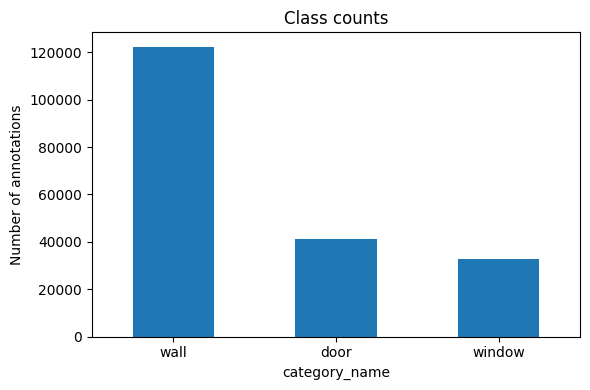

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import random

PROJECT_ROOT = Path(r"E:\test_work")
DATA_ROOT = PROJECT_ROOT / "cubicasa5k-2.v1i.coco"

TRAIN_ANN_PATH = DATA_ROOT / "train" / "_annotations.coco.json"
IMAGES_DIR = DATA_ROOT / "train"


with open(TRAIN_ANN_PATH, "r", encoding="utf-8") as f:
    coco = json.load(f)

print(coco.keys())
print("images:", len(coco["images"]))
print("annotations:", len(coco["annotations"]))
print("categories:", len(coco["categories"]))


images_df = pd.DataFrame(coco["images"])
ann_df = pd.DataFrame(coco["annotations"])
cats_df = pd.DataFrame(coco["categories"])

display(images_df.head())
display(ann_df.head())
display(cats_df)

cat_id_to_name = dict(zip(cats_df["id"], cats_df["name"]))
ann_df["category_name"] = ann_df["category_id"].map(cat_id_to_name)

class_counts = ann_df["category_name"].value_counts().sort_values(ascending=False)
print(class_counts)

plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar")
plt.title("Class counts")
plt.ylabel("Number of annotations")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


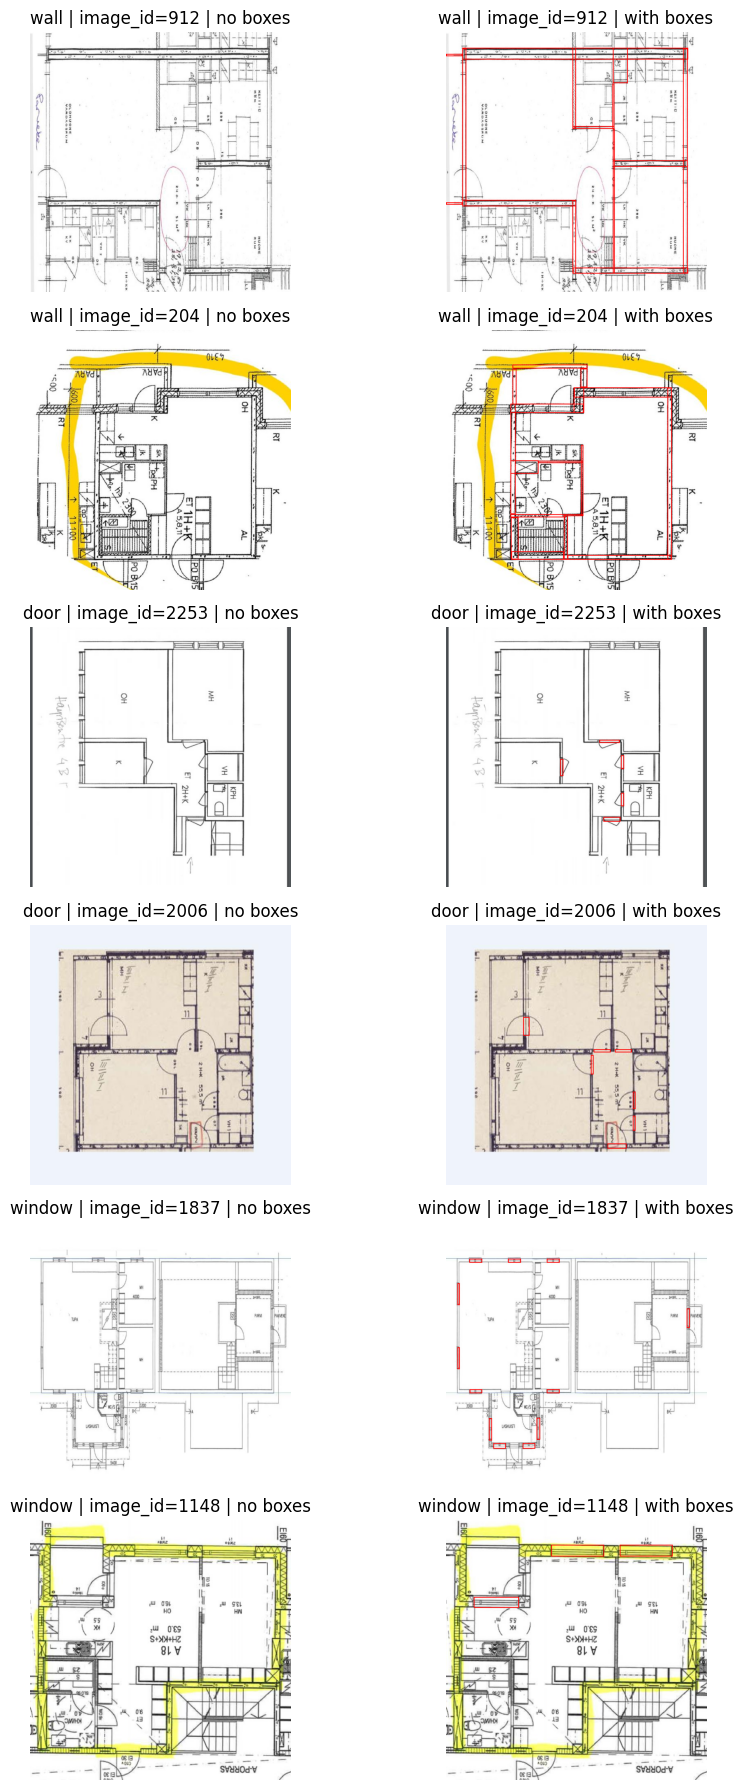

In [2]:
random.seed(42)

categories = ["wall", "door", "window"]
n_examples_per_cat = 2  #по 2 примера на категорию

n_rows = len(categories) * n_examples_per_cat
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 3 * n_rows))

if n_rows == 1:
    axes = axes.reshape(1, 2)

row = 0

for cat in categories:
    img_ids = ann_df[ann_df["category_name"] == cat]["image_id"].unique()
    chosen_ids = random.sample(list(img_ids), k=min(n_examples_per_cat, len(img_ids)))

    for img_id in chosen_ids:
        img_meta = images_df[images_df["id"] == img_id].iloc[0]
        file_name = img_meta["file_name"]
        img_path = IMAGES_DIR / file_name

        # оригинал
        img = Image.open(img_path).convert("RGB")
        anns_for_img_cat = ann_df[
            (ann_df["image_id"] == img_id) &
            (ann_df["category_name"] == cat)
        ]
        ax_left = axes[row, 0]
        ax_left.imshow(img)
        ax_left.set_title(f"{cat} | image_id={img_id} | no boxes")
        ax_left.axis("off")

        img_boxes = img.copy()
        draw = ImageDraw.Draw(img_boxes)
        for _, ann in anns_for_img_cat.iterrows():
            x, y, w, h = ann["bbox"]  # COCO: [x, y, width, height]
            draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

        ax_right = axes[row, 1]
        ax_right.imshow(img_boxes)
        ax_right.set_title(f"{cat} | image_id={img_id} | with boxes")
        ax_right.axis("off")

        row += 1

plt.tight_layout()
plt.show()
